In [556]:
###### valido para Julia 1.7.2
using LinearAlgebra
using Plots
using Graphs #paquetería para graphos
using Random
using GraphPlot #paqueteria para graficar redes
using SparseArrays
using LaTeXStrings

In [557]:
fnt = Plots.font("sans-serif", 15) # Para gráficar loas labels


Plots.Font("sans-serif", 15, :hcenter, :vcenter, 0.0, RGB{N0f8}(0.0,0.0,0.0))

In [558]:
F(theta,i,j,k)=exp(im*theta*i*j/k) #son las entradas de la matriz, las exponenciales

function Coin_Fourier(k,theta=2*pi)   #genera la matriz
    
    Cki=zeros(Complex,k,k)

    
    Cki[1,:].=1                # se le agrega 1's a la primera fila
    Cki[:,1].=1                # se le agrega 1's a la primera columna
    for i=1:k-1                #  En este for se va a recorrer cada fila y columna
        for j=1:k-1               ## junto con este otro for
            Cki[j+1,i+1]=F(theta,i,j,k) # se utiliza la función F que se definio arriba
        end
    end
    
    if k==2
        
        ###Este es un parche para un anillo##
        C=zeros(2,2)
        C[1,1]=0
        C[1,2]=1
        C[2,1]=1
        C[2,2]=0
        ######################################
       return (1/sqrt(k))*(C*Cki)  # se le multiplica por el 1/sqrt(grado) al que corresponde 
    else
       return (1/sqrt(k))*(Cki) 
    end
end


## Neceisto algo que si le doy un nodo me diga que base se le asigna###
function Base_del_Nodo(Nodo,A)
    k=sum(A[Nodo,:]) # Sumamos cada entrada eso nos dará el grado del nodo
    Id=Matrix(1I, k, k) # generamos la matriz identidad que corresponde al grado
    return Id #La retorna
              ## Esto genera la base segun sea el grado de cada nodo
end

Base_del_Nodo (generic function with 1 method)

In [559]:
Coin_Fourier(2)*sqrt(2)

2×2 Matrix{ComplexF64}:
 1.0+0.0im  -1.0+1.22465e-16im
 1.0+0.0im   1.0+0.0im

In [560]:
function U_evolution(n,A,ψ)

    ### Para ver que vectores hay tenemos que recorrer cada uno... PARA UNA MATRIZ ψ DADA
    for t=1:n
        for i=1:size(A)[1]   #PAra un nodo i me va a dar el vector que le corresponde Ö

            if rowvals(ψ[i,:])==[]       # si no hay ningún peso entonces continua
               continue 
            else
               #println(ψ[i,:]) 
            end

            Nodos_de_i=rowvals(A[i,:])   # vecinos del nodo i
            Basis=Base_del_Nodo(i,A)     # base del nodo i


            v=zeros(length(Nodos_de_i)) # el vector del nodo i
            for (index,value) in enumerate(Nodos_de_i)   # hacemos dos indices uno que enlista los elemntos y otro los nodos conectados al nodos i
            v+=Basis[:,index]*ψ[i,value]
            end


            #Al vector le aplicamos el operador moenda
            k=sum(A[i,:])  # calculamos
            v=Coin_Fourier(k)*v  ## El vector despues de la moenda de Fourier 
            
            
            # Hay que reemplazar los pesos (SEGUIMOS EN EL NODO 1)
            for (index,value) in enumerate(Nodos_de_i)   # hacemos dos indices uno que enlista los elemntos y otro los nodos conectados al nodos 1
                ψ[i,value]=v[index]
            end

        end            #
        
        ### operador S### es solo el trasnpuesto de la matriz ψ
        ψ=sparse(transpose(ψ))
    end
    return ψ
end

U_evolution (generic function with 1 method)

# Entropia
Solo sirve para quiralidad uniforme es decir en este caso 2

In [561]:
function Density_M_Q(Q,A,Z)
    Dst=zeros(ComplexF64,Q,Q) # Q es el grado más alto
    for m=1:NODOS # Construimos la matriz de densidad
        #println(m)
        for (jk,val_jk) in enumerate(rowvals(A[m,:]))
            for (jkp,val_jkp) in enumerate(rowvals(A[m,:]))
                #println((val_jk,val_jkp),"=",(conj(Z[m,val_jkp]),conj(Z[m,val_jk])))
                Dst[jk,jkp]+=conj(Z[m,val_jkp])*Z[m,val_jk]
                
#                 if m==1 || m==NODOS
#                     Dst[jkp,jk]+=ψ[m,val_jk]*conj(ψ[m,val_jkp])
#                 end
            end
        end
    end
    return Dst
end

Density_M_Q (generic function with 1 method)

In [562]:
#coeficientes iniciales

an(n,sigm,gam)=sqrt(exp(-n^2/(2*sigm^2))/(sqrt(2*pi*sigm^2)))*cos(gam/2)    
bn(n,sigm,gam,phi)=sqrt(exp(-n^2/(2*sigm^2))/(sqrt(2*pi*sigm^2)))*sin(gam/2)*exp(phi*im)
bn(n,sigm,gam)=sqrt(exp(-n^2/(2*sigm^2))/(sqrt(2*pi*sigm^2)))*sin(gam/2)

bn (generic function with 2 methods)

In [563]:
function ψ_inital_gauss(phi)
    ψ=sparse(zeros(Complex,size(A))) ## Creo la matriz de coeficientes psi
    
    init=-(Nd_central-1)          # ahora buscamos el número que corresponde a la posición de la teoria si esn 9 entoces es -4
    #print(Nd_central," ",init)

    ##PRIMERO
    ψ[1,NODOS]=an(init+(1-1),sigm,gam)          # usamos la condicion inicial de un estado de un gaussian walker
    ψ[1,2]=bn(init+(1-1),sigm,gam,phi)          # usamos la condicion inicial de un estado de un gaussian walker
    ########
    ###ULTIMO
    ψ[NODOS,NODOS-1]=an(init+(NODOS-1),sigm,gam)          # usamos la condicion inicial de un estado de un gaussian walker
    ψ[NODOS,1]=bn(init+(NODOS-1),sigm,gam,phi)          # usamos la condicion inicial de un estado de un gaussian walker
    ########
    for i=2:NODOS-1 ## Llenamos los estados con los qbits iniciales con an y bn
        ψ[i,i-1]=an(init+(i-1),sigm,gam)          # usamos la condicion inicial de un estado de un gaussian walker
        ψ[i,i+1]=bn(init+(i-1),sigm,gam,phi)          # usamos la condicion inicial de un estado de un gaussian walker
    end;
    return ψ
end

function ψ_inital_gauss()
    ψ=sparse(zeros(Complex,size(A))) ## Creo la matriz de coeficientes psi
    
    init=-(Nd_central-1)          # ahora buscamos el número que corresponde a la posición de la teoria si esn 9 entoces es -4
    #print(Nd_central," ",init)

    ##PRIMERO
    ψ[1,NODOS]=an(init+(1-1),sigm,gam)          # usamos la condicion inicial de un estado de un gaussian walker
    ψ[1,2]=bn(init+(1-1),sigm,gam)          # usamos la condicion inicial de un estado de un gaussian walker
    ########
    ###ULTIMO
    ψ[NODOS,NODOS-1]=an(init+(NODOS-1),sigm,gam)          # usamos la condicion inicial de un estado de un gaussian walker
    ψ[NODOS,1]=bn(init+(NODOS-1),sigm,gam)          # usamos la condicion inicial de un estado de un gaussian walker
    ########
    for i=2:NODOS-1 ## Llenamos los estados con los qbits iniciales con an y bn
        ψ[i,i-1]=an(init+(i-1),sigm,gam)          # usamos la condicion inicial de un estado de un gaussian walker
        ψ[i,i+1]=bn(init+(i-1),sigm,gam)          # usamos la condicion inicial de un estado de un gaussian walker
    end;
    return ψ
end

ψ_inital_gauss (generic function with 2 methods)

# PROGRAMA

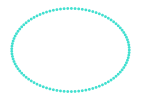

In [571]:
#Red de prueba
NODOS=101

g = SimpleGraph(NODOS)  #defeinimos nodos de 1 al 3

for i=1:NODOS-1
   add_edge!(g,i,i+1)  
end
add_edge!(g,NODOS,1)

#add_edge!(g,90,7)

gplot(g, #nodelabel=1:NODOS,
    layout=circular_layout)   #graficamos la red

#gplot(watts_strogatz(NODOS,2,0.5), nodelabel=1:NODOS,layout=circular_layout)

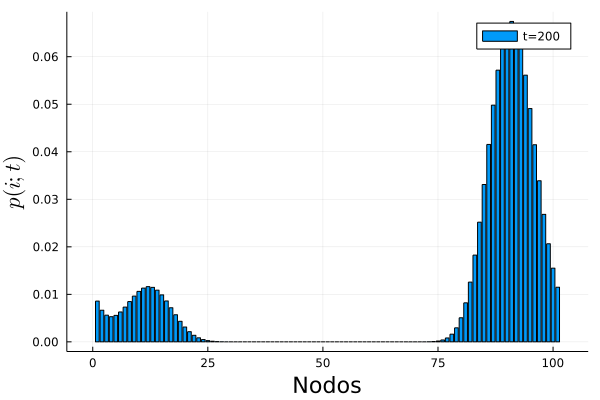

In [664]:
A=adjacency_matrix(g);
Nd_central=Int64((NODOS-1)/2 +1)
sigm=5
gam=π/2
phi=π/2

ψ=ψ_inital_gauss()

Pasos=200

B=U_evolution(Pasos,A,ψ)
BB=abs2.(Matrix(B));

pesos=zeros(size(A)[1])
for i=1:length(pesos)
    pesos[i]=sum(BB[i,:])
end
bar(pesos,guidefont=fnt,ylabel=L"p(i;t)",xlabel="Nodos",label="t=$Pasos")


┌ Info: Saved animation to 
│   fn = /home/sebas/Escritorio/Cosas de Git/Tesis_MAestria/quantum-walks-julia/Anillo/GAussian_walker.gif
└ @ Plots /home/sebas/.julia/packages/Plots/lW9ll/src/animation.jl:137


Plots.AnimatedGif("/home/sebas/Escritorio/Cosas de Git/Tesis_MAestria/quantum-walks-julia/Anillo/GAussian_walker.gif")
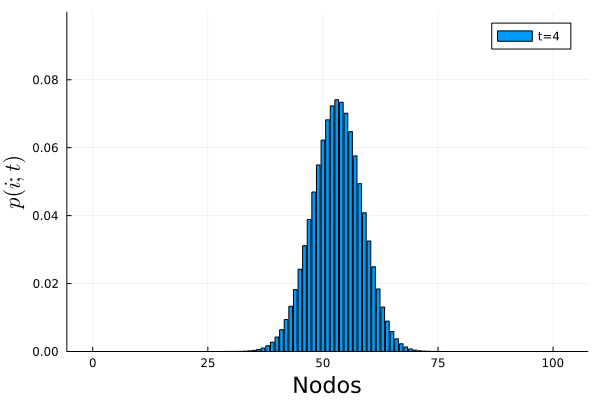

In [671]:

anim= @animate for l=4:1:148
    ψ=ψ_inital_gauss()
    B=U_evolution(l,A,ψ)
    BB=abs2.(Matrix(B))
    pesos=zeros(size(A)[1])
    for i=1:length(pesos)
        pesos[i]=sum(BB[i,:])
    end
    bar(pesos,guidefont=fnt,ylabel=L"p(i;t)",xlabel="Nodos",label="t=$l",ylim=(0,0.1))
end
gif(anim,"./GAussian_walker.gif", fps=50)



In [665]:
###ENTROPIA

n=Pasos
Sn=zeros(n)


### Buscamos el grado más alto
grado_m=0
for i=1:NODOS
    if sum(A[i,:])>grado_m
        grado_m=sum(A[i,:])
    end
end
Q=grado_m
#####

for i=1:n
    ψ=ψ_inital_gauss()
    Dst=Density_M_Q(Q,A,U_evolution(i,A,ψ))
    lamb=eigvals(Dst)
    for j=1:Q
        if lamb[j]<=0
            continue
        else
            Sn[i]-=lamb[j]*log(lamb[j])
        end
    end
end

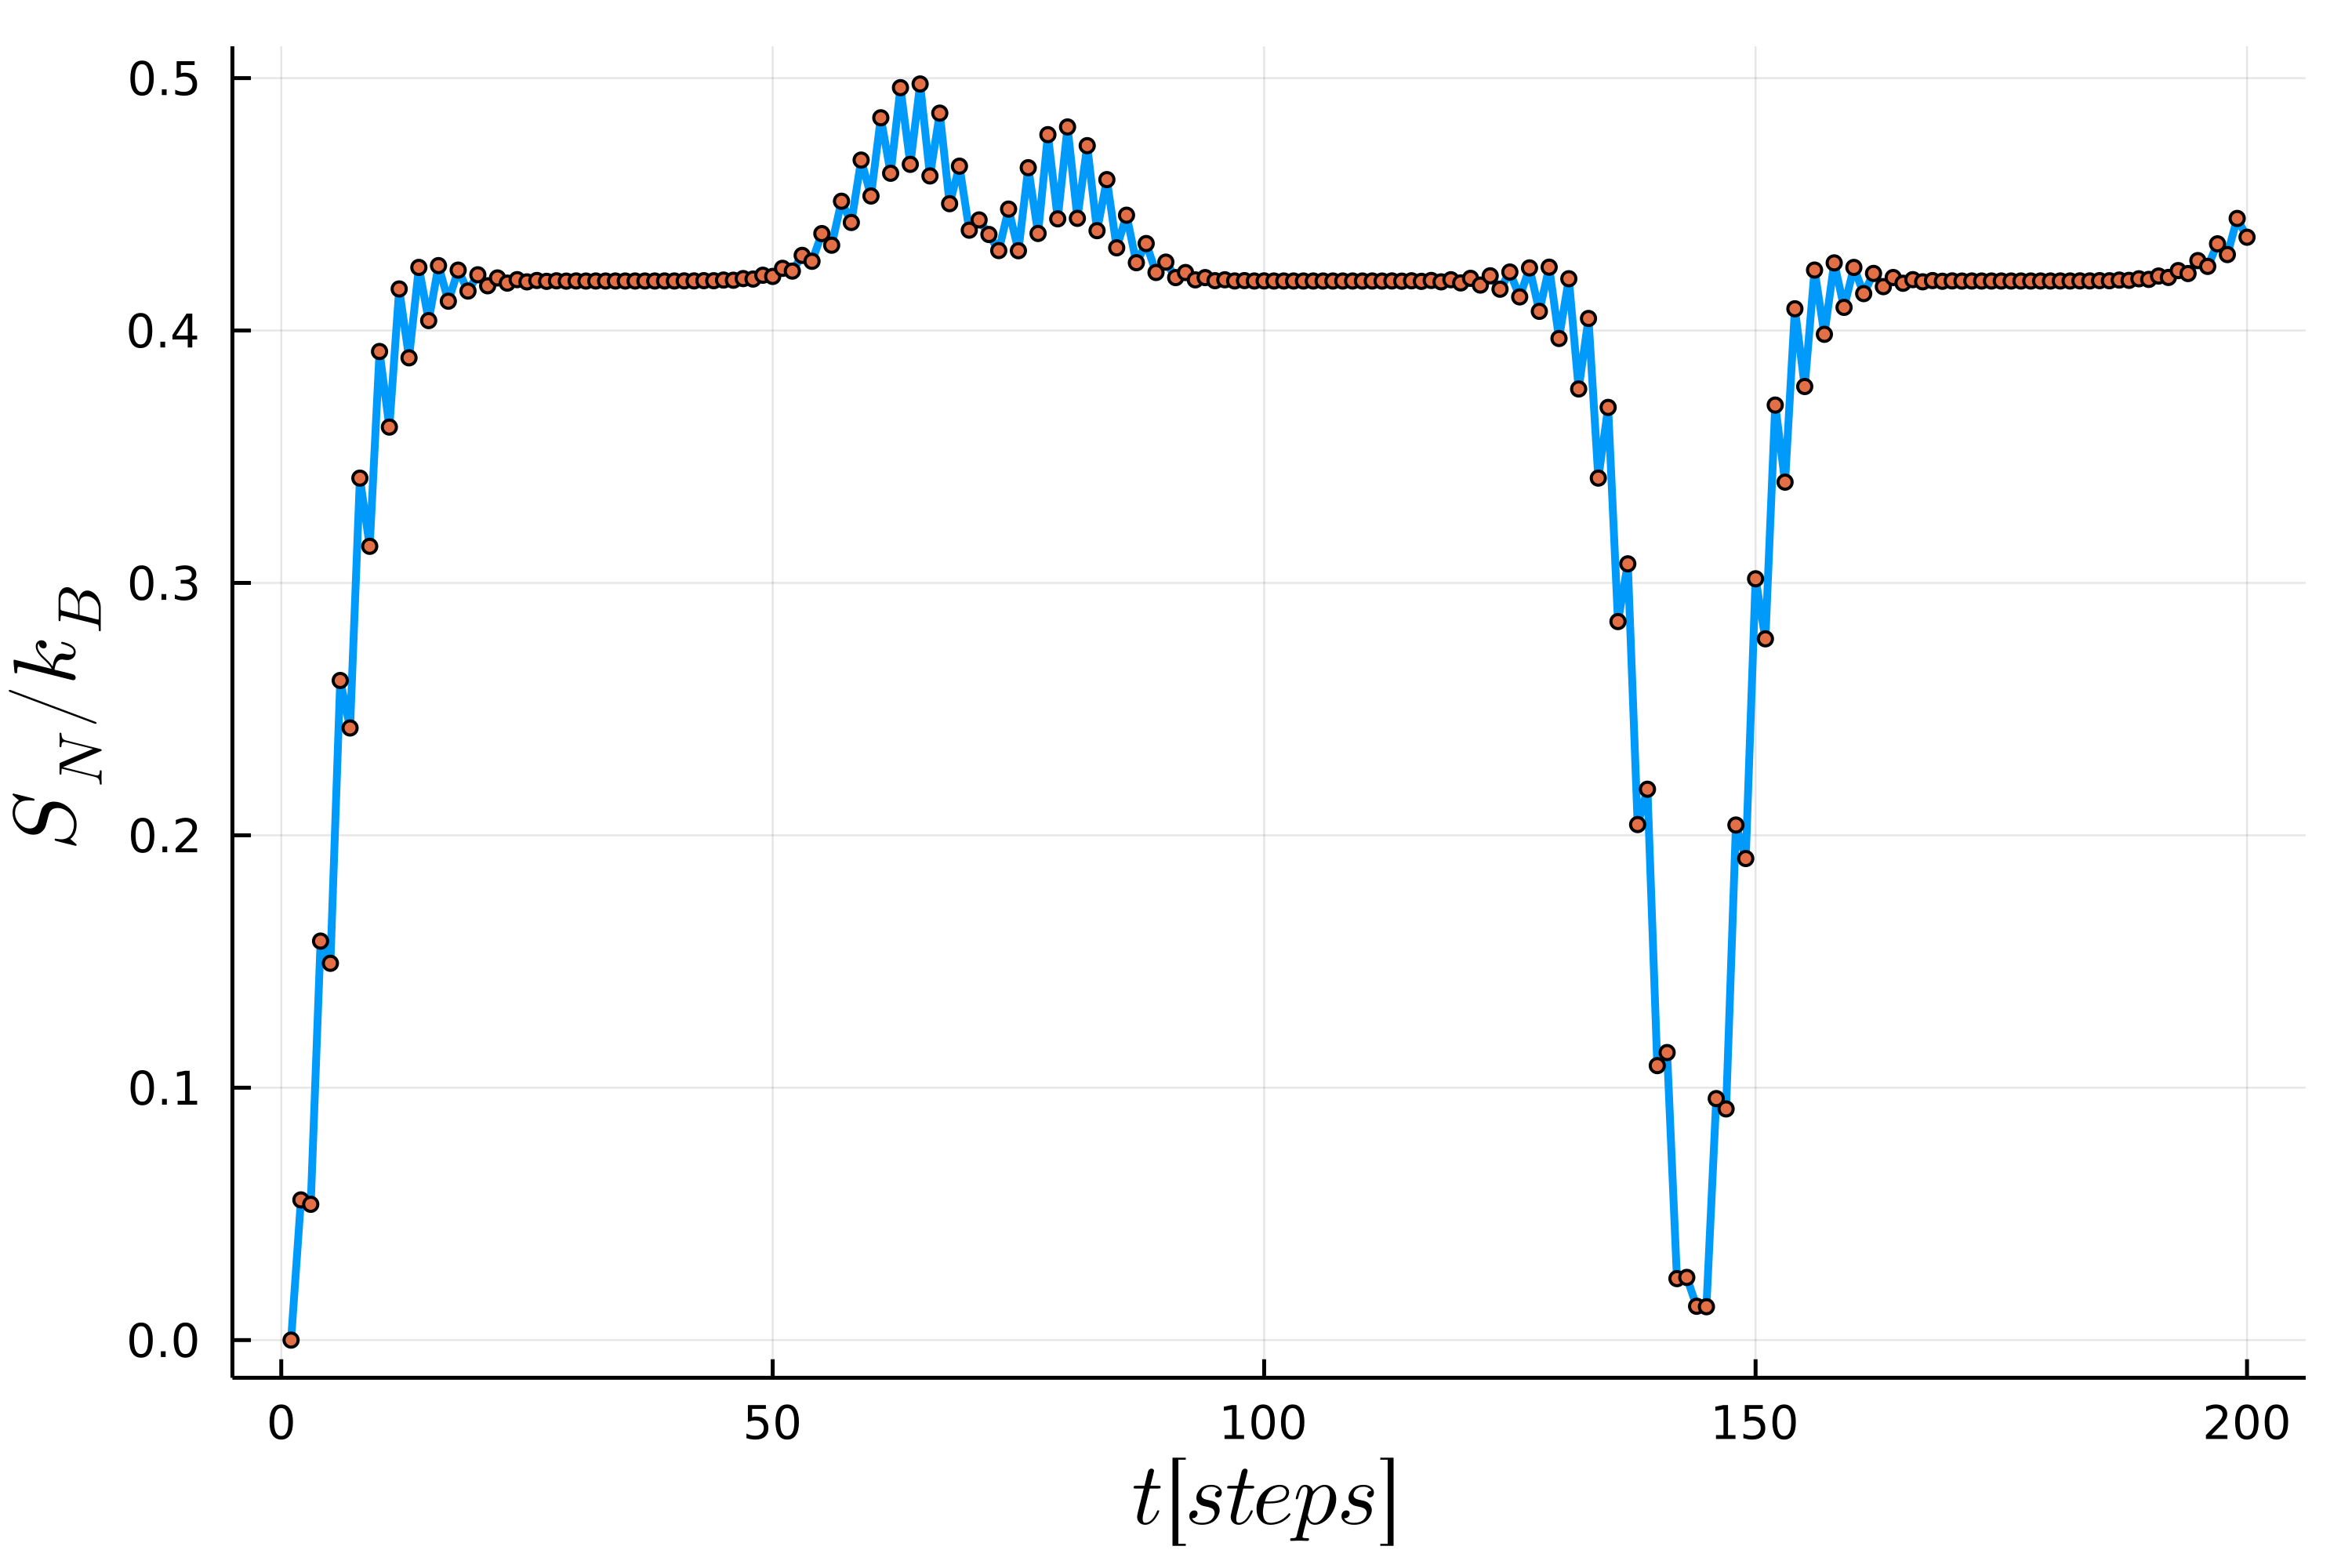

In [672]:
plot(Sn[1:end],ylabel=L"S_N/k_B",xlabel=L"t[steps]",label=false,#label="\\sigma="*"$sigm",
    guidefont=fnt,legend=:bottomright,
    legendfontsize=12.0,lw = 2,
    #xlims=(0,150)#,ylims=(0.604,0.605)
    )
scatter!(Sn[1:end],label=false,markersize=2, fmt = :png, dpi=500 )


In [673]:
savefig("./Gaussian_walker.png")

In [659]:
? savefig()

```
savefig([plot,] filename)
```

Save a Plot (the current plot if `plot` is not passed) to file. The file type is inferred from the file extension. All backends support png and pdf file types, some also support svg, ps, eps, html and tex.


In [651]:
0.001

0.001